In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler

from qiskit import Aer, QuantumCircuit,QuantumRegister
from qiskit.circuit import Parameter
from qiskit.circuit.library import  ZZFeatureMap, MCMT, RYGate, PhaseGate, RZGate
from qiskit.opflow import Z, I
from qiskit.utils import  algorithm_globals
from qiskit.algorithms.optimizers import SPSA
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_state_qsphere
from qiskit.quantum_info import partial_trace


from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier

from IPython.display import clear_output

from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 42
hamiltonian = Z ^ I ^ I


from Aux_Data import plot_predicted, plot_area, plot_bloch_sphere
from QWNN import angle_encoding_2qubits, neuron
from Aux_QuantumML import get_opflow_qnn


In [4]:

def apply_circuit(param_x1, param_x2, x1, x2, x3, x4):
	qc = QuantumCircuit(3)
	qc.ry(param_x1, 0)
	qc.ry(param_x2, 1)
	qc.x(0)
	qc.x(1)
	qc.append(MCMT(RYGate(x1), 2,1), [0,1,2])
	qc.x(1)
	qc.append(MCMT(RYGate(x2), 2,1), [0,1,2])
	qc.x(0)
	qc.x(1)
	qc.append(MCMT(RYGate(x3), 2,1), [0,1,2])
	qc.x(1)
	qc.append(MCMT(RYGate(x4), 2,1), [0,1,2])
	return qc

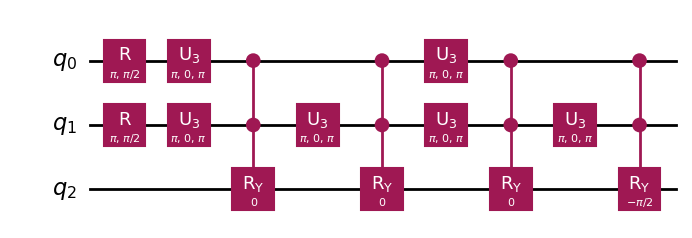

In [5]:
circ = QuantumCircuit(3)
circ.append(apply_circuit(np.pi,np.pi,0,0,0,-np.pi/2), [0,1,2])
circ.decompose().decompose().draw('mpl', style='iqx')

In [6]:
backend = Aer.get_backend('statevector_simulator')
qc_compiled = transpile(circ, backend)
job = backend.run(qc_compiled, shots=1024)
result = job.result()
counts = result.get_counts(qc_compiled)
print(counts)


{'011': 0.5, '111': 0.5}


In [7]:
state = result.get_statevector(qc_compiled)
print(state)

Statevector([-0.        +0.j,  0.        +0.j,  0.        +0.j,
              0.70710678+0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j, -0.70710678+0.j],
            dims=(2, 2, 2))


In [11]:
state_new = partial_trace(state, [0,1])
state_new.data

array([[ 0.5+0.j, -0.5+0.j],
       [-0.5+0.j,  0.5+0.j]])

In [6]:
state[7]

(-0.7071067811865476+0j)

In [7]:
opflow_classifier = NeuralNetworkClassifier.load("neuron_spsa_pi.model")
qnn = opflow_classifier.neural_network
theta = opflow_classifier._fit_result.x
theta

array([ 1.71028379,  3.13095626, -0.07296113, -0.12472416])

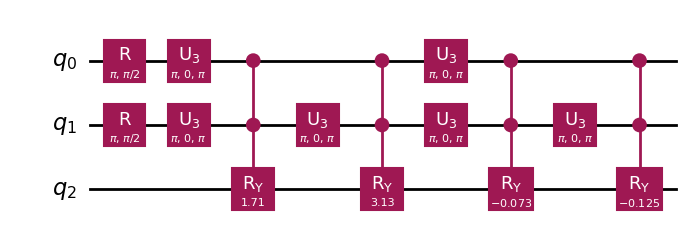

In [8]:
circ = QuantumCircuit(3)
circ.append(apply_circuit(np.pi,np.pi,theta[0], theta[1], theta[2], theta[3]), [0,1,2])
circ.decompose().decompose().draw('mpl', style='iqx')

In [9]:
backend = Aer.get_backend('statevector_simulator')
qc_compiled = transpile(circ, backend)
job = backend.run(qc_compiled, shots=1024)
result = job.result()
state = result.get_statevector(qc_compiled)
print(state)

Statevector([ 0.        +0.j,  0.        +0.j,  0.        +0.j,
              0.99805612+0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j, -0.06232167+0.j],
            dims=(2, 2, 2))


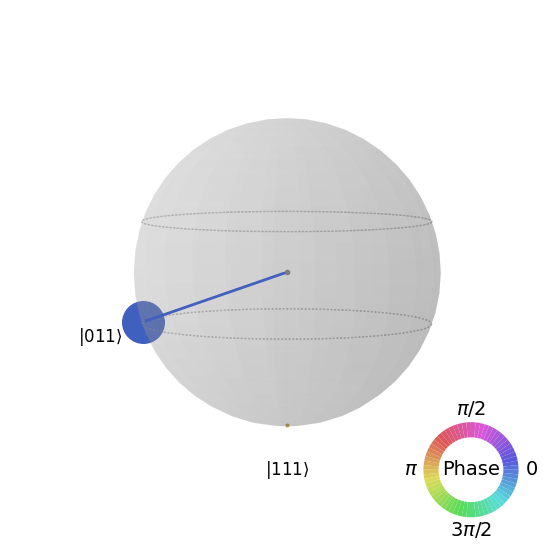

In [10]:
plot_state_qsphere(state)